In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pywt
from math import log10, sqrt
import pydicom as dcm
import os
import pandas as pd
import csv
import imutils

In [2]:
def img_read(x):
    img=cv2.imread(x,0)
    return img
def watermark_read(x):
    wtr_img=cv2.imread(x,0)
    wtr_img=cv2.resize(wtr_img,(64,64))
    return wtr_img

In [3]:
import random
def hcf(a,b):
    if(b%a==0):
        return a
    else:
        return hcf(b%a,a)
def randomseq(size):
    random.seed(size)
    
    num=[x for x in range(size)]
    h=len(num)
    for m in range(h):
        if m>2:
            r=hcf(m,h)
            if r==1:
                break 
    i=random.randint(0,size-1)    
    x=i
    res=[]
    while True:
        i=(i+m)%h
        if i==x:
            break
        res.append(i)
        
    res.append(x)
    return res

In [4]:
def toBinary(j):
    temp=bin(j).replace('0b',"")
    temp2=temp[::-1]
    while len(temp2)<8:
        temp2+='0'
    temp=temp2[::-1]
    if(j<0):
        temp=temp.replace('-',"")
        temp[1:]
        temp="1"+temp
    return temp
def toDecimal(j):
    temp=str(j)
    temp2=temp[::-1]
    while(len(temp2)<8):
        temp2+='0'
    temp=temp2[::-1]
    j=temp
    # if(j[0]=="1"):
    #     j=j[1:]
    #     return -int(j,2)
    # else:
    #     j=j[1:]
    #     return int(j,2)
    return int(j,2)


In [5]:

def calcRedundantBits(m):
	for i in range(m):
		if(2**i >= m + i + 1):
			return i

def posRedundantBits(data, r):
	j = 0
	k = 1
	m = len(data)
	res = ''
	for i in range(1, m + r+1):
		if(i == 2**j):
			res = res + '0'
			j += 1
		else:
			res = res + data[-1 * k]
			k += 1
	return res[::-1]


def calcParityBits(arr, r):
	n = len(arr)
	for i in range(r):
		val = 0
		for j in range(1, n + 1):
			if(j & (2**i) == (2**i)):
				val = val ^ int(arr[-1 * j])
		arr = arr[:n-(2**i)] + str(val) + arr[n-(2**i)+1:]
	return arr


def detectError(arr, nr):
	n = len(arr)
	res = 0
	for i in range(nr):
		val = 0
		for j in range(1, n + 1):
			if(j & (2**i) == (2**i)):
				val = val ^ int(arr[-1 * j])
		res = res + val*(10**i)
	return int(str(res), 2)

def implementecc(bindata):
	output=''
	for i in range(0,len(bindata),8):
		data=bindata[i:i+8]
		m=len(data)
		r=calcRedundantBits(m)
		arr=posRedundantBits(data,r)
		arr=calcParityBits(arr,r)
		output+=str(arr)
	return output,r

def removeerror(outdata,r):
	output=''
	for i in range(0,len(outdata),12):
		data=outdata[i:i+12]
		pos=detectError(data,r)
		if pos==0:
			temp=data[0:4]+data[5:8]+data[9]
		else:
			pos=len(data)-pos+1
			if data[pos-1]=='0':
				data=data[0:pos-1]+'1'+data[pos:]
			else:
				data=data[0:pos-1]+'0'+data[pos:]
			temp=data[0:4]+data[5:8]+data[9]	
		output+=temp
	return output


In [6]:
def binarycoversion(wtr_img):
    list_wtr_img=""
    for i in wtr_img:
        for j in i:
            list_wtr_img+=toBinary(j)
    return list_wtr_img

In [7]:
def embedding(img,list_wtr_img):
    # wrow,wcol=wtr_img.shape
    (row,col)=img.shape
    # LL,(HL,LH,HH)=pywt.dwt2(img,wavelet='haar')
    LL=img
    lrow,lcol=LL.shape
    l4x4=LL.reshape(-1,2,2)
    ustore=[]
    vstore=[]
    sstore=[]
    t=0
    for i in l4x4:
        u,s,v=np.linalg.svd(i)
        t+=abs(u[0][0]-u[1][0])
        # u[1,0],u[2,0]=u[2,0],u[1,0]
        ustore.append(u)
        vstore.append(v)
        sstore.append(s)
    t=t/len(ustore)
    # print(list_wtr_img)
    # len(ustore)
    seq=randomseq(len(ustore))
    k=0
    for i in seq:
        if k==len(list_wtr_img):
            break
        if list_wtr_img[k]=='0':
            if ustore[i][0][0]<=ustore[i][1][0]:
                ustore[i][0][0],ustore[i][1][0]=ustore[i][1][0],ustore[i][0][0]
            if ustore[i][0][0]-ustore[i][1][0]<t:
                ustore[i][0][0]+=t/2
                ustore[i][1][0]-=t/2
        else:
            if ustore[i][0][0]>ustore[i][1][0]:
                ustore[i][0][0],ustore[i][1][0]=ustore[i][1][0],ustore[i][0][0]
            if ustore[i][1][0]-ustore[i][0][0]<t:
                ustore[i][1][0]+=t/2
                ustore[i][0][0]-=t/2
        k+=1
    newll=[]
    for i in range(len(sstore)):
        u=ustore[i]
        v=vstore[i]
        s=sstore[i]
        temp=u@np.diag(s)@v
        newll.append(temp)
    newll=np.array(newll)
    newll=newll.ravel()
    newll=newll.reshape(lrow,lcol)
    # plt.imshow(newll,cmap='gray')
    # watermarked_img=pywt.idwt2((newll,(HL,LH,HH)),wavelet='haar')
    return newll

In [8]:
def recover(watermarked_img,l):
    # dLL,(dHL,dLH,dHH)=pywt.dwt2(watermarked_img,wavelet='haar')
    dLL=watermarked_img
    dl2x2=dLL.reshape(-1,2,2)
    rec=''

    seq=randomseq(dl2x2.shape[0])
    k=0
    for i in seq:
        if k==l:
            break
        u,s,v=np.linalg.svd(dl2x2[i])
        if u[0][0]>u[1][0]:
            rec+='0'
        else:
            rec+='1'
        k+=1
    # generated_wtr=np.zeros((wrow,wcol),dtype='uint8')
    # count=0
    # for i in range(wrow):
    #     for j in range(wcol):
    #         temp=rec[count:count+8]
    #         count+=8
    #         generated_wtr[i,j]=toDecimal(temp)
    # return generated_wtr
    return rec

In [9]:
def decodewatermark(rec,wrow,wcol):
    generated_wtr=np.zeros((wrow,wcol),dtype='uint8')
    count=0
    for i in range(wrow):
        for j in range(wcol):
            temp=rec[count:count+8]
            count+=8
            generated_wtr[i,j]=toDecimal(temp)
    return generated_wtr

In [10]:
def umatrixwatermarking(cover,wtr_img):
    bstring1=binarycoversion(wtr_img)
    bstring=bstring1
    extra=8-len(bstring)%8
    if extra!=8:
        for i in range(extra):
            bstring+='0'
    else:
        extra=0
    newbstring,r=implementecc(bstring)
    stego=embedding(cover,newbstring)
    return stego,len(newbstring),r,extra,bstring1
def umatrixextraction(stego,l,r,extra):
    decoded=recover(stego,l)
    org=removeerror(decoded,r)
    if extra!=0:
        org=org[0:-extra]
    # input_string=int(org,2)
    # decoded_str=input_string.to_bytes((input_string.bit_length()+7)//8,'big').decode()
    # return decoded_str,org_dec
    return org

In [11]:
from sklearn.metrics import mean_squared_error

def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    try:
        max_pixel = 255.0
        psnr = 20 * log10(max_pixel / sqrt(mse))
        return psnr
    except:
        return -9999  #When MSE is Zero, i.e, no noise is present in the image

In [12]:
import random
def salt_pepper(img,p):
    new=img.copy()
    x,y=img.shape
    pixels=int(x*y*p)
    sp=[]
    for i in range(pixels):
        sp.append((random.randint(0,y-1),random.randint(0,x-1),random.choice([0,4096])))
    for i,j,v in sp:
        new[i,j]=v
    return new
def gauss_noise(img,mean,variance):
    s=variance**2
    x,y=img.shape
    r=np.random.normal(mean,s,(y,x))
    return img+r
from skimage.metrics import structural_similarity

def ssim(name,name1):
    return structural_similarity(name,name1)
def crop(img,d):
    new=img.copy()
    x,y=img.shape
    x1=(x-d)//2
    y1=(y-d)//2
    new[y1:y1+d,x1:x1+d]=255
    return new

In [13]:
def norm_data(data):
    mean_data=np.mean(data)
    std_data=np.std(data,ddof=1)
    return (data-mean_data)/(std_data)
def ncc(data0,data1):
    c=(1.0/(data0.size-1))*np.sum(norm_data(data0)*norm_data(data1))
    return c

In [14]:
def medianfilter(img):
    im=img.copy()
    rows=im.shape[0]
    cols=im.shape[1]
    for i in range(1,rows-1):
        for j in range(1,cols-1):
            temp_array=[im[i][j],im[i-1][j],im[i+1][j],im[i][j-1],im[i][j+1],im[i-1][j-1],im[i-1][j+1],im[i+1][j-1],im[i+1][j+1]]
            temp_array.sort()
            # print(temp_array)
            im[i][j]=temp_array[4]
            temp_array=None
    return im

In [15]:
# # images=os.listdir('../datasets/BOSSbase_1.01_DATASET/BOSSbase_1.01')
# images=os.listdir('./CoverImages')
# watermarks=os.listdir('./CoverImages')
# # imgpath='../datasets/BOSSbase_1.01_DATASET/BOSSbase_1.01'
# imgpath='./CoverImages'
# wtrpath='./CoverImages'
# ssim_list=[]
# psnr_list=[]
# imagelist=[]
# watermarklist=[]
# ncc_list=[]
# c=0
# test_wtr=[watermarks[0],watermarks[1],watermarks[7]]

# # i=watermarks[0]
# for i in test_wtr:
#     count=0
#     wtr_img=watermark_read(os.path.join(wtrpath,i))
#     name_folder=i.split('.')
#     name_folder=name_folder[0]
#     path=f'D:/CS/Sem_6/Project/Completed Work/Output/SIPIU/rotate45/{name_folder}'
#     os.mkdir(path)
#     for j in images:
#         img=img_read(os.path.join(imgpath,j))
#         watermarked_img=embedding(img,wtr_img)
#         wrow,wcol=wtr_img.shape
#         name="wtr_"+i+'_host_'+j
#         cv2.imwrite(os.path.join(path,f'{name}_noAtk.jpg'),watermarked_img)



#         # atk=crop(watermarked_img,50)
#         atk=imutils.rotate(watermarked_img,45)
#         # atk=gauss_noise(watermarked_img,0.01,0.01)
#         # atk=salt_pepper(watermarked_img,0.001)
#         # atk=np.round(watermarked_img)
#         # for i in range(atk.shape[0]):
#         #     for j in range(atk.shape[1]):
#         #         atk[i][j]=int(atk[i][j])
#         # atk=watermarked_img.astype('uint8')
#         # atk=cv2.equalizeHist(atk)
#         # atk=medianfilter(watermarked_img)

#         # atk=cv2.imread(os.path.join(path,f'{name}_noAtk.jpg'),0)
#         atk2=imutils.rotate(atk,-45)
#         generated_with_atk=recover(atk2,wrow,wcol)
#         generated_img=recover(watermarked_img,wrow,wcol)






#         # path=f'D:/CS/Sem 6/Project/Practice/Output/BOSBaseUsingUMatrixMethod/{name_folder}'
#         cv2.imwrite(os.path.join(path,f'{name}_withAtk.jpg'),atk)
#         cv2.imwrite(os.path.join(path,f'{name}_watermark.jpg'),generated_img)
#         cv2.imwrite(os.path.join(path,f'{name}_watermarkWithAtk.jpg'),generated_with_atk)
#         ssim_score=ssim(wtr_img,generated_with_atk)
#         psnr_score=PSNR(img,watermarked_img)
#         psnr_list.append(psnr_score)
#         ssim_list.append(ssim_score)
#         imagelist.append(j)
#         watermarklist.append(i)
#         ncc_list.append(ncc(wtr_img,generated_with_atk))
#         count+=1
#         if count>=10:
#             break
#     c+=1


In [16]:
# col=['Image','Watermark','SSIM','NCC','PSNR']
# df=pd.DataFrame(columns=col)
# df['Image']=imagelist
# df['Watermark']=watermarklist
# df['SSIM']=ssim_list
# df['NCC']=ncc_list
# df['PSNR']=psnr_list

In [17]:
# df.to_csv('./Output/SIPIU/rotate45.csv')

In [18]:
# import tifffile as tf
# cover=cv2.imread("./CoverImages/lena.tiff",0)
# # cover+=2048
# wtr=watermark_read('./CoverImages/peeper.tiff')
# en,l,r,ex,b=umatrixwatermarking(cover,wtr)
# # cv2.imwrite('./stegoattack.jpg',en)
# # atk=img_read('./stegoattack.jpg')
# # atk=salt_pepper(en,0.01)
# # atk=medianfilter(en)
# rec=umatrixextraction(en,64*64*12,4,0)
# ret=decodewatermark(rec,wtr.shape[0],wtr.shape[1])
# plt.imshow(ret,cmap='gray')

In [19]:
# plt.imshow(en,cmap='gray')

In [20]:
# PSNR(en,cover)

In [21]:
print(32*32*12)

12288


In [22]:
# ex

In [23]:
# ncc(wtr,ret)

In [24]:
# coverpath='./CoverImages'
# watermarkpath='./CoverImages'
# images=os.listdir(coverpath)
# watermarks=os.listdir(watermarkpath)
# psnr_list=[]
# imagelist=[]
# watermarklist=[]
# ncc_list=[]
# c=0
# test_wtr=[watermarks[0],watermarks[1],watermarks[7]]
# for i in test_wtr:
#     count=0
#     wtr=watermark_read(os.path.join(watermarkpath,i))
#     name_folder=i.split('.')
#     name_folder=name_folder[0]
#     path=f'D:/CS/Sem_6/Project/Completed Work/Output/HammingSIPIU/histeq/{name_folder}'
#     os.mkdir(path)
#     for j in images:
#         cover=img_read(os.path.join(coverpath,j))
#         en,l,r,ex,b=umatrixwatermarking(cover,wtr)


#         # atk=crop(en,50)
#         # atk=img_read(os.path.join(path,f'{name}_attacked.jpg'))
#         # atk=salt_pepper(en,0.001)
#         # atk=gauss_noise(en,0.01,0.01)
#         # atk=crop(en,100)
#         # atk=np.round(en)
#         # for i in range(atk.shape[0]):
#         #     for j in range(atk.shape[1]):
#         #         atk[i][j]=int(atk[i][j])
#         atk=en.astype('uint8')
#         atk=cv2.equalizeHist(atk)


#         rec=umatrixextraction(atk,l,r,ex)
#         ret=decodewatermark(rec,wtr.shape[0],wtr.shape[1])

#         name="wtr_"+i+'_host_'+j
#         cv2.imwrite(os.path.join(path,f'{name}_attacked.jpg'),atk)
#         cv2.imwrite(os.path.join(path,f'{name}_stego.jpg'),en)
#         cv2.imwrite(os.path.join(path,f'{name}_watermark.jpg'),wtr)
#         cv2.imwrite(os.path.join(path,f'{name}_ret_wtr.jpg'),ret)
#         psnr_score=PSNR(cover,en)
#         psnr_list.append(psnr_score)
#         imagelist.append(j)
#         watermarklist.append(i)
#         ncc_list.append(ncc(wtr,ret))
#         count+=1
#         if count>=10:
#             break
#     c+=1
        

In [25]:
# col=['Image','Watermark','NCC','PSNR']
# df=pd.DataFrame(columns=col)
# df['Image']=imagelist
# df['Watermark']=watermarklist
# df['NCC']=ncc_list
# df['PSNR']=psnr_list

In [26]:
# df.to_csv('./Output/HammingSIPIU/histeq.csv')

In [27]:
im=img_read("xray1.jpeg")
wtr=watermark_read("logo.jpg")

In [28]:
cover=im[512:1024,512:1024]
cover.shape

(512, 512)

In [29]:
en,l,r,ex,b=umatrixwatermarking(cover,wtr)
en1=salt_pepper(en,0.001)
en2=salt_pepper(en,0.002)
en3=salt_pepper(en,0.003)
en4=salt_pepper(en,0.004)
en5=salt_pepper(en,0.005)

rec1=umatrixextraction(en1,64*64*12,4,0)
rec2=umatrixextraction(en2,64*64*12,4,0)
rec3=umatrixextraction(en3,64*64*12,4,0)
rec4=umatrixextraction(en4,64*64*12,4,0)
rec5=umatrixextraction(en5,64*64*12,4,0)
ret1=decodewatermark(rec1,wtr.shape[0],wtr.shape[1])
ret2=decodewatermark(rec2,wtr.shape[0],wtr.shape[1])
ret3=decodewatermark(rec3,wtr.shape[0],wtr.shape[1])
ret4=decodewatermark(rec4,wtr.shape[0],wtr.shape[1])
ret5=decodewatermark(rec5,wtr.shape[0],wtr.shape[1])

nc1=ncc(wtr,ret1)
nc2=ncc(wtr,ret2)
nc3=ncc(wtr,ret3)
nc4=ncc(wtr,ret4)
nc5=ncc(wtr,ret5)


# plt.imshow(ret,cmap='gray')


In [30]:
print(nc1,nc2,nc3,nc4,nc5)

1.0000000000000002 0.9984017216688652 0.9984996875775819 0.9974547291623128 0.996830938351111


In [31]:
random_array = np.random.randint(0, 256, size=(512, 512))
wtr_data=np.random.randint(0, 256, size=(32, 32))
en,l,r,ex,b=umatrixwatermarking(random_array,wtr_data)
rec=umatrixextraction(en,64*64*12,4,0)
ret=decodewatermark(rec,wtr_data.shape[0],wtr_data.shape[1])

In [32]:
ncc(wtr_data,ret)

0.9122140015644646

In [33]:
random_array

array([[145, 155,  87, ..., 189, 158, 122],
       [161,  13,  57, ..., 114, 109, 131],
       [188,  91, 149, ..., 231,   5,  49],
       ...,
       [244,   9, 237, ...,   4,  66,  47],
       [ 15, 162, 172, ...,  84, 232, 234],
       [ 93,  72, 248, ..., 209,  15,  25]])

In [34]:
# en.astype(int)

In [35]:
PSNR(random_array,en)

18.64297146838292

In [36]:
image=img_read("./Coverimages/airplane.tiff")
test=image[0:8,0:8]
watermark=watermark_read("./Coverimages/airplane.tiff")
twtr=watermark[0:1,0:1]
en,l,r,ex,b=umatrixwatermarking(test,twtr)
rec=umatrixextraction(en,1*1*12,4,0)
ret=decodewatermark(rec,twtr.shape[0],twtr.shape[1])

In [37]:
twtr

array([[184]], dtype=uint8)

In [38]:
ret

array([[184]], dtype=uint8)

In [39]:
test

array([[ 65, 199, 193, 185, 179, 185, 191, 189],
       [ 54, 196, 192, 195, 195, 192, 191, 192],
       [ 54, 197, 194, 197, 195, 191, 191, 188],
       [ 55, 187, 187, 188, 186, 180, 180, 182],
       [ 62, 181, 180, 180, 180, 183, 182, 183],
       [ 69, 174, 174, 178, 179, 179, 181, 186],
       [ 72, 180, 179, 174, 174, 181, 179, 180],
       [ 77, 176, 171, 168, 170, 175, 169, 174]], dtype=uint8)

In [40]:
binarycoversion(twtr)

'10111000'

In [41]:
en.astype(int)

array([[ 65, 199, 192, 185, 164, 170, 205, 203],
       [ 54, 196, 191, 195, 177, 174, 208, 209],
       [ 99, 262, 148, 131, 195, 191, 191, 188],
       [ 55, 187, 187, 188, 200, 194, 165, 167],
       [ 62, 180, 180, 179, 165, 168, 196, 197],
       [107, 226, 135, 125, 179, 178, 180, 185],
       [ 72, 180, 179, 174, 189, 197, 163, 163],
       [107, 216, 140, 127, 155, 160, 183, 188]])

In [42]:
PSNR(test,en)

21.161000587119865

In [43]:
from tabulate import tabulate
print(tabulate(test,tablefmt="grid"))

+----+-----+-----+-----+-----+-----+-----+-----+
| 65 | 199 | 193 | 185 | 179 | 185 | 191 | 189 |
+----+-----+-----+-----+-----+-----+-----+-----+
| 54 | 196 | 192 | 195 | 195 | 192 | 191 | 192 |
+----+-----+-----+-----+-----+-----+-----+-----+
| 54 | 197 | 194 | 197 | 195 | 191 | 191 | 188 |
+----+-----+-----+-----+-----+-----+-----+-----+
| 55 | 187 | 187 | 188 | 186 | 180 | 180 | 182 |
+----+-----+-----+-----+-----+-----+-----+-----+
| 62 | 181 | 180 | 180 | 180 | 183 | 182 | 183 |
+----+-----+-----+-----+-----+-----+-----+-----+
| 69 | 174 | 174 | 178 | 179 | 179 | 181 | 186 |
+----+-----+-----+-----+-----+-----+-----+-----+
| 72 | 180 | 179 | 174 | 174 | 181 | 179 | 180 |
+----+-----+-----+-----+-----+-----+-----+-----+
| 77 | 176 | 171 | 168 | 170 | 175 | 169 | 174 |
+----+-----+-----+-----+-----+-----+-----+-----+


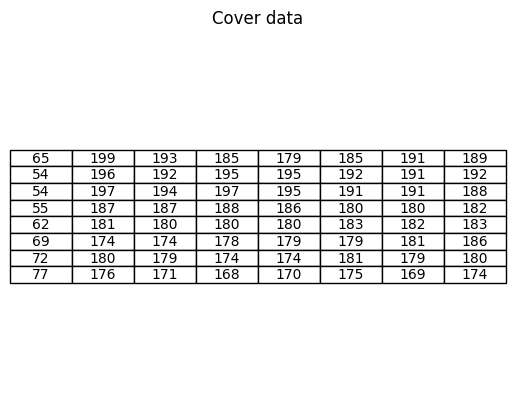

In [44]:
table = plt.table(cellText=test, loc='center', cellLoc='center')
ax = plt.gca()
ax.axis('off')
plt.title("Cover data")
# Show the plot
plt.show()